# Imports

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from catboost import CatBoostClassifier, Pool

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import FunctionTransformer, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline

# Load dataset

In [2]:
X = pd.read_csv("../../data/training_set_features.csv").drop("respondent_id", axis=1)
Y = pd.read_csv("../../data/training_set_labels.csv").drop("respondent_id", axis=1)

features = list(X)
targets = list(Y)

target = targets[0]

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42, shuffle=True,
    stratify=Y)

for df in [X_train, X_test, y_train, y_test]:
    df.reset_index(drop=True, inplace=True)

cat_features = [i for i in range(len(features))]
text_features = list(X_train.select_dtypes(object))

# Preprocessing

In [4]:
def to_str(x):
    return x.astype(str)


class FeatureSelector(BaseEstimator, TransformerMixin):

    def __init__(self, feature_names=None):
        self.feature_names = feature_names 

    def fit(self, X, y = None):
        return self 

    def transform(self, X, y = None):
        if self.feature_names is None:
            return X
        return X[self.feature_names]
    
    
class DataFrameTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, feature_names=None):
        self.feature_names = feature_names 

    def fit(self, X, y = None):
        return self 

    def transform(self, X, y = None):
        return pd.DataFrame(X, columns=self.feature_names)

In [5]:
selected_features = list(features)

pipeline = Pipeline(steps=[
    (
        'preprocessing',
        Pipeline(steps=[
            ('feature_selector', FeatureSelector(selected_features)),
            ('fillna', SimpleImputer(strategy='constant', fill_value="nan", copy=False)),
            ('to_str', FunctionTransformer(to_str)),
            ('to_df', DataFrameTransformer(selected_features))
        ])
    )
])

pipeline.fit(X_train)
X_train_processed = pipeline.transform(X_train)
X_test_processed = pipeline.transform(X_test)

# Classifier Chain

In [69]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.multioutput import ClassifierChain

import itertools


class CatboostClassifierTuned(BaseEstimator):
    def __init__(
        self,
        cat_features=None,
        parameters_grid=None,
        **kwargs
    ):
        """
        A Custom BaseEstimator that can switch between classifiers.
        :param estimator: sklearn object - The classifier
        """
        self.estimator = CatBoostClassifier(**kwargs)
        self.parameters_grid = parameters_grid
        self.cat_features = cat_features

    def fit(self, X, y=None, plot=False, **kwargs):
        self.classes_ = unique_labels(y)
        self.features = list(X)
        self.target = y.name
        train_pool = Pool(
            data=X,
            label=y,
            cat_features=self.cat_features
        )

        if self.parameters_grid is not None:
            print("HP tuning fit")
            randomized_search_result = self.estimator.randomized_search(self.parameters_grid,
                                                                        X=train_pool,
                                                                        plot=plot,
                                                                        verbose=False)
        else:
            print("Regular Fit")
            self.estimator.fit(train_pool)

        return self

    def predict(self, X, y=None):
        pool = Pool(
            data=X,
            label=y,
            cat_features=self.cat_features
        )
        return self.estimator.predict(pool)

    def predict_proba(self, X, y=None):
        pool = Pool(
            data=X,
            label=y,
            cat_features=self.cat_features
        )
        return self.estimator.predict_proba(pool)[:, 1]

    def score(self, X, y):
        predictions = self.predict_proba(X, y)
        return roc_auc_score(y, predictions)

    def eval_metrics(self, X, y, metrics=['Logloss', 'AUC']):
        pool = Pool(
            data=X,
            label=y,
            cat_features=self.cat_features
        )

        metrics = model.eval_metrics(
            data=pool,
            metrics=['Logloss', 'AUC'],
            ntree_start=0,
            ntree_end=0,
            eval_period=1,
            plot=True
        )
        return metrics

    def get_model_info(self):
        return {"num_features": len(self.features),
                "target": self.target}


class CatboostClassifierChain(BaseEstimator):
    def __init__(self, order, cat_features=None, **kwargs):
        self.order = order
        self.num_models = len(order)
        self.cat_features = cat_features
        self.chain = [CatboostClassifierTuned(
            cat_features=cat_features, **kwargs) for _ in range(len(order))]

#     def fit(self, X, y):
#         self.y_columns = list(y)

#         for index in range(self.num_models):
#             as_features = self.order[:index]
#             current_target = self.order[index]
#             X_temp = pd.concat([X, y.iloc[:, as_features]],
#                                axis=1)
#             self.chain[index].fit(X=X_temp, y=y.iloc[:, current_target])
#         return self

    def fit(self, X, y):
        self.y_columns = list(y)
        X_temp = X.copy()
        for index in range(self.num_models):
            pred_name = self.y_columns[self.order[index]]
            current_target = self.order[index]
            self.chain[index].fit(X=X_temp, y=y.iloc[:, current_target])
            X_temp[pred_name] = self.chain[index].predict_proba(X_temp)
        return self

    def predict_proba(self, X, y=None):
        X_temp = X.copy()
        for index in range(self.num_models):
            pred_name = self.y_columns[self.order[index]]
            X_temp[pred_name] = self.chain[index].predict_proba(X_temp)
        self.X_temp = X_temp
        return X_temp.iloc[:, -self.num_models:][self.y_columns]

    def score(self, X, y):
        predictions = self.predict_proba(X, y)
        return roc_auc_score(y, predictions)


class CatboostClassifierChainEnsemble(BaseEstimator):
    def __init__(self, cat_features=[], orders=[], bootstrap_samples=1, bootstrap_size=1, **kwargs):
        """
        A Custom BaseEstimator that can switch between classifiers.
        :param estimator: sklearn object - The classifier
        """
        self.cat_features = cat_features
        self.orders = orders
        self.kwargs = kwargs
        self.bootstrap_samples = bootstrap_samples
        self.bootstrap_size = bootstrap_size

    def build_chains(self):
        self.chains = [CatboostClassifierChain(**self.kwargs,
                                               cat_features=self.cat_features,
                                               order=order)
                       for order in self.orders for _ in range(self.bootstrap_samples)]

        return self

    def fit(self, X, y=None, **kwargs):
        self.classes_ = unique_labels(y)

        if len(self.orders) == 0:
            self.orders = list(
                map(list, list(itertools.permutations([i for i in range(y.shape[1])]))))

        self.build_chains()

        for chain in self.chains:
            rows = np.random.binomial(1, self.bootstrap_size, size=len(X)).astype('bool')
            subset_X = X[rows]
            subset_y = y[rows]
            chain.fit(subset_X, subset_y)

        return self

    def predict(self, X, y=None):
        return self.estimator.predict(X)

    def predict_proba(self, X, y=None):
        Y_pred_chains = np.array([chain.predict_proba(X).values for chain in
                                  self.chains])

        Y_pred_ensemble = Y_pred_chains.mean(axis=0)
        return Y_pred_ensemble

    def score(self, X, y):
        predictions = self.predict_proba(X, y)
        return roc_auc_score(y, predictions)

In [62]:
grid = {'learning_rate': [0.03],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9],
        'grow_policy': ['Lossguide', 'Depthwise', 'SymmetricTree']}

model_params = {"cat_features": cat_features,
                "parameters_grid": None,
                "iterations": 2000,
                "task_type": "GPU",
                "devices": '0:1',
                "custom_loss": ['AUC:hints=skip_train~false'],
                "early_stopping_rounds": 50,
                "logging_level": 'Silent'}

In [8]:
model_seasonal = CatboostClassifierTuned(**model_params)

model_seasonal.fit(X_train_processed, y_train['seasonal_vaccine'])
test_predictions_seasonal = model_seasonal.predict_proba(X_test_processed, y=y_test['seasonal_vaccine'])
model_seasonal.score(X_test_processed, y_test['seasonal_vaccine'])

HP tuning fit


0.8674511030259997

In [9]:
model_h1n1 = CatboostClassifierTuned(**model_params)

model_h1n1.fit(X_train_processed, y_train['h1n1_vaccine'])
test_predictions_h1n1 = model_h1n1.predict_proba(X_test_processed, y=y_test['h1n1_vaccine'])
model_h1n1.score(X_test_processed, y_test['h1n1_vaccine'])

HP tuning fit


0.8705004840186339

In [10]:
br_predictions = pd.DataFrame({"h1n1_vaccine": test_predictions_h1n1,
                               "seasonal_vaccine": test_predictions_seasonal})

print(roc_auc_score(y_test, br_predictions))

0.8689757935223168


In [11]:
model_ensemble = CatboostClassifierChainEnsemble(**model_params)

model_ensemble.fit(X_train_processed, y_train)
model_ensemble.score(X_test_processed, y_test)

HP tuning fit
HP tuning fit
HP tuning fit
HP tuning fit


0.8670489487971502

In [12]:
for model_chain in model_ensemble.chains:
    print(model_chain.score(X_test_processed, y_test))

0.8633583253857825
0.8662856129571129


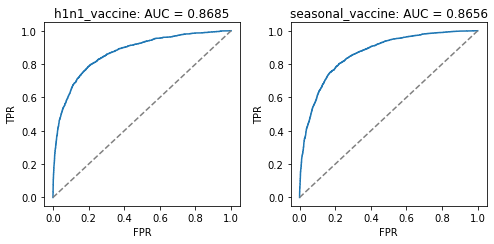

In [13]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )
    
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))

ensemble_predicts = model_ensemble.predict_proba(X_test_processed)

plot_roc(
    y_test['h1n1_vaccine'], 
    ensemble_predicts[:, 0], 
    'h1n1_vaccine',
    ax=ax[0]
)
plot_roc(
    y_test['seasonal_vaccine'], 
    ensemble_predicts[:, 1], 
    'seasonal_vaccine',
    ax=ax[1]
)
fig.tight_layout()

# Feature Importance

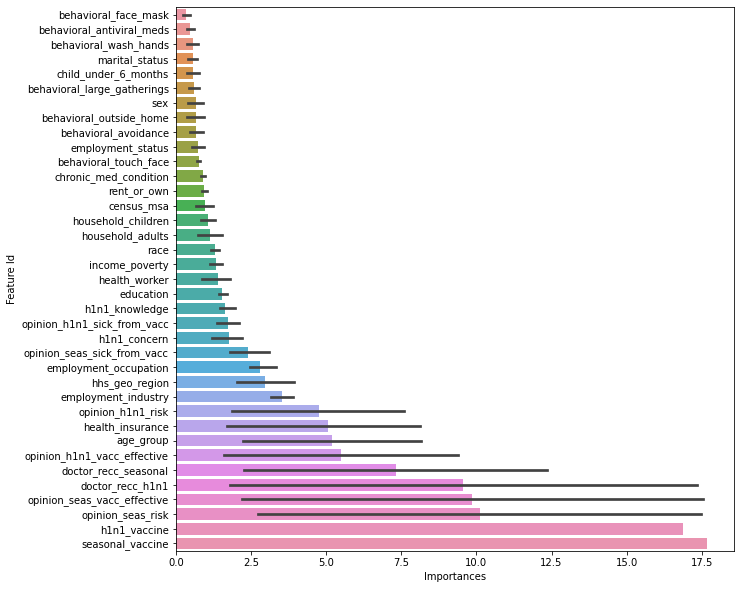

In [14]:
def ensemble_feature_importance(model_ensemble):

    grouped_importance = pd.DataFrame()
    for model_chain in model_ensemble.chains:
        for model in model_chain.chain:
            single_importance = model.estimator.get_feature_importance(
                prettified=True)

            grouped_importance = pd.concat(
                [grouped_importance, single_importance], axis=0)

    avg_importance = grouped_importance.groupby("Feature Id")["Importances"].mean().sort_values()
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.barplot(data=grouped_importance, x="Importances", y="Feature Id", ax=ax,
                order=avg_importance.index)
    
    return pd.DataFrame(avg_importance)

importance_df = ensemble_feature_importance(model_ensemble)

# Full Pipeline

In [64]:
def build_pipeline(selected_features, model_params):
    pipeline = Pipeline(steps=[
        (
            'preprocessing',
            Pipeline(steps=[
                ('feature_selector', FeatureSelector(selected_features)),
                ('fillna', SimpleImputer(strategy='constant', fill_value="nan", copy=False)),
                ('to_str', FunctionTransformer(to_str)),
                ('to_df', DataFrameTransformer(selected_features))
            ])
        ),
        (
            'estimator', CatboostClassifierChainEnsemble(**model_params))
    ])
    return pipeline

In [65]:
model_params = {"cat_features": selected_features,
                "parameters_grid": None,
                "bootstrap_samples": 1,
                "bootstrap_size": 1,
                "iterations": 2000,
                "task_type": "GPU",
                "devices": '0:1',
                "custom_loss": ['AUC:hints=skip_train~false'],
                "early_stopping_rounds": 50,
                "logging_level": 'Silent'}

In [52]:
model_params['parameters_grid'] = grid

selected_features = list(features)

pipeline = build_pipeline(selected_features, model_params)

pipeline.fit(X_train, y_train)
X_train_predictions = pipeline.predict_proba(X_train)
X_test_predictions = pipeline.predict_proba(X_test)

print(f"Train AUC: {pipeline.score(X_train, y_train)}")
print(f"Test AUC: {pipeline.score(X_test, y_test)}")

# pipeline.fit(X, Y)

None

HP tuning fit
HP tuning fit
HP tuning fit
HP tuning fit
Train AUC: 0.9482718784571409
Test AUC: 0.867358640524917


In [70]:
model_params.update({"parameters_grid": grid,
                     "bootstrap_size": 0.8,
                     "bootstrap_samples": 3})

selected_features = list(features)

pipeline = build_pipeline(selected_features, model_params)

pipeline.fit(X_train, y_train)
X_train_predictions = pipeline.predict_proba(X_train)
X_test_predictions = pipeline.predict_proba(X_test)

print(f"Train AUC: {pipeline.score(X_train, y_train)}")
print(f"Test AUC: {pipeline.score(X_test, y_test)}")

# pipeline.fit(X, Y)

None

HP tuning fit
HP tuning fit
HP tuning fit
HP tuning fit
HP tuning fit
HP tuning fit
HP tuning fit
HP tuning fit
HP tuning fit
HP tuning fit
HP tuning fit
HP tuning fit
Train AUC: 0.9380559912642253
Test AUC: 0.8688395085729843


# Submission

In [71]:
X_holdout = pd.read_csv("../../data/test_set_features.csv")

holdout_predictions = pipeline.predict_proba(X_holdout.drop("respondent_id", axis=1))

In [72]:
submission_df = pd.DataFrame(holdout_predictions, columns=['h1n1_vaccine', 'seasonal_vaccine'])
submission_df['respondent_id'] = X_holdout['respondent_id']

submission_df[['respondent_id', 'h1n1_vaccine', 'seasonal_vaccine']].to_csv("../submissions/catboost_classifier_chain.csv", index=False)